![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FWorking+With%2FDocument+AI&dt=Document+AI+-+From+BigQuery.ipynb)


# Document AI - From BigQuery
> From the [Working With Document AI](https://github.com/statmike/vertex-ai-mlops/blob/main/Working%20With/Document%20AI/readme.md) series in the [vertex-ai-mlops](https://github.com/statmike/vertex-ai-mlops/blob/main/readme.md) repository.

---
**Processing Scecifics For BigQuery**

Notes are current as of the preview release [November 13, 2023](https://cloud.google.com/bigquery/docs/release-notes#November_13_2023)
- The dataset/table need to be in the same region as the remote model - this must be US or EU multi-region for Document AI.
- (currently) there are not paramters for setting processing inputs, like OCR configuration and add ons
- The service has the same limit as online processing, 15 pages per document
- (currently) the functionality only work with [Enterprise and Enterprise Plus editions](https://cloud.google.com/bigquery/docs/editions-intro)
    - running a query with `ML.PROCESS_DOCUMENT` requires a reservation
- The only part of the processing response that is returned are entities, not pages (currently)
---

[Document AI](https://cloud.google.com/document-ai/docs/overview) is an API where you interact with processors to extract information from documents.  You enable the API, create an instance of a processor in your project, send in document(s), receive back JSON with the extracted information:

<p align="center" width="100%"><center>
    <img src="../../architectures/architectures/images/working with/documentai/readme/high_level.png">
</center></p>

This workflow covers using BigQuery to do both the document processing and the response processing.  

<p align="center" width="100%"><center>
    <img src="../../architectures/architectures/images/working with/documentai/bigquery.png">
</center></p>

> For complete details on other ways to use process documents and responses check out these other workflows:
>- [Document AI - Process Documents](./Document%20AI%20-%20Process%20Documents.ipynb)
>    - How to process 1 or many documents
>    - Examples of Batch and Online Processing
>    - Async Processing
>    - Storing results in GCS and/or BigQuery
>    - Recalling results from GCS and/or BigQuery
>- [Document AI - Process Responses](./Document%20AI%20-%20Process%20Responses.ipynb)
>    - Extracting elements from the JSON in Python or in BigQuery with SQL
>    - Treating elements like geographies for advanced extraction techniques

---

**Documents**

Document AI sources are documents.  There are many supported document types (file formats):
- Supported [Document Types](https://cloud.google.com/document-ai/docs/file-types) like pdf, gif, tiff, jpeg, pn, gmp, webp
- Additional support for [DocX files is in preview](https://cloud.google.com/document-ai/docs/enterprise-document-ocr#supported_file_formats).

For BigQuery processing, document should be provided in an [object table](https://cloud.google.com/bigquery/docs/object-table-introduction).  This is essential a table with column that contains the GCS URIs of the documents.

---

**Processing**

To launch the processessing request for the document the [ML.PROCESS_DOCUMENT](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-process-document) function is used in a SQL query statement.

---

**Responses**

With BigQuery function [ML.PROCESS_DOCUMENT](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-process-document) the results are returned as a JSON value where SQL can be used to extract the parts of the documenta needed for an application.

---

**References:**

- BigQuery function [ML.PROCESS_DOCUMENT](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-process-document)
- [Document AI Overview](https://cloud.google.com/document-ai/docs/overview)
    - [Send a processing request](https://cloud.google.com/document-ai/docs/send-request)
    - [Handling the processing response](https://cloud.google.com/document-ai/docs/handle-response)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Working%20With/Document%20AI/Document%20AI%20-%20From%20BigQuery.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [3]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [4]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [66]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.documentai', 'google-cloud-documentai'),
    ('google.cloud.documentai', 'google-cloud-storage'),
    ('google.cloud.documentai', 'google-cloud-bigquery'),
    ('google.cloud.bigquery_connection_v1', 'google-cloud-bigquery-connection'),
    ('PyPDF2', 'PyPDF2')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### API Enablement

In [67]:
!gcloud services enable documentai.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [68]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [69]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [74]:
REGION = 'us-central1'
SERIES = 'working-with-docai'
EXPERIMENT = 'from-bigquery'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID

# BigQuery Objects
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE_PREFIX = EXPERIMENT
BQ_REGION = REGION[0:2]

Packages

In [71]:
import os, shutil, glob, json, asyncio, datetime, io

import PyPDF2

from google.cloud import documentai
from google.cloud import storage
from google.cloud import bigquery
from google.cloud import bigquery_connection_v1 as bq_connection

Clients

In [72]:
# document AI client
LOCATION = REGION.split('-')[0]
docai = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# bq client
bq = bigquery.Client(project = PROJECT_ID)

---
## Documents

This section prepares a document for processing with BigQuery using `ML.PROCESS_DOCUMENT`.  This requires the document(s) to be in GCS buckets and an identified in a BigQuery object table by the related GCS URIs.

`../shared files/docs/bill.pdf`

### Get The Document

If you are working from a clone of this notebooks repository then the document is already present. The following cell checks for the documents folder, `../shared_files/docs`, and if it is missing gets the document used in this workflow (`wget`):

In [114]:
file = '../shared files/docs/bill.pdf'

if not os.path.exists(file):
    print('Retrieving document...')
    if not os.path.exists(os.path.dirname(file)):
      os.makedirs(os.path.dirname(file))
    import requests, urllib.parse
    r = requests.get(f'https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Working%20With/{urllib.parse.quote(file[3:])}')
    open(file, 'wb').write(r.content)
    print(f'Document now at `{file}`')
else:
    print(f'Document Found at `{file}`')

Document Found at `../shared files/docs/bill.pdf`


### Prepare Documents And Save To GCS

The 15 page size limit means some documents might need to be split into multiple parts for complete OCR processing in this workflow.  This section detectx the number of pages and creates multi-part documents.  The parts (or full files) are then save to GCS.

In [118]:
glob.glob(file)

['../shared files/docs/bill.pdf']

In [119]:
for file in glob.glob(file):
    # open the full file
    with open(file, 'rb') as pdf:
        doc = pdf.read()
        
    # read file, get number of pages, calc the number of parts with up to 15 pages
    reader = PyPDF2.PdfReader(io.BytesIO(doc))
    num_pages = len(reader.pages)
    num_shards = num_pages // 15 + 1 * min(1, num_pages % 15)
    
    # split file into parts, save all parts to GCS
    pdfs = []
    if num_shards > 1:
        for shard in range(num_shards):
            pdfs.append(PyPDF2.PdfWriter())
        for page in range(num_pages):
            pdfs[page // 15].add_page(reader.pages[page])
        for p, pdf in enumerate(pdfs):
            blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/{file[3:-4]} - part {p+1} of {len(pdfs)}.pdf')
            with blob.open("wb", content_type = 'application/pdf') as f:
                pdf.write(f)
    else:
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/{file[3:]}')
        blob.upload_from_filename(file)

In [120]:
print(f"View the bucket directly here:\nhttps://console.cloud.google.com/storage/browser/{GCS_BUCKET}/{SERIES}/{EXPERIMENT};tab=objects&project={PROJECT_ID}")

View the bucket directly here:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915/working-with-docai/from-bigquery;tab=objects&project=statmike-mlops-349915


List files in bucket:

In [121]:
for blob in list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/shared files/docs')):
    print(blob.name)

working-with-docai/from-bigquery/shared files/docs/bill.pdf


---
## Processors

When submitting documents for processing in Document AI, the client routes the document to a processor.  There are many processors:
- [Full processor and detail list](https://cloud.google.com/document-ai/docs/processors-list)
- Check out the helpful table for processors in this workflows [readme file](./readme.md) 

When setting up a processor you can also pick versions or it will default to a version.

This section shows how to:
- list available processors in the project: console and Python Client
    - describe processor(s)
- get/create a processor with desired type and version


### List Processors In This Project

If any have already been created, list them:

What are the processors already created in this project environment?

In [122]:
processors = list(docai.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'))
len(processors)

7

In [123]:
if processors:
    print(f'View the processors in the console with this link:\nhttps://console.cloud.google.com/ai/document-ai/processors?project={PROJECT_ID}\n\n')
    for p, processor in enumerate(processors):
        print(
            f'Processors {p}: ', processor.display_name, 
            '\n\tis of type = ', processor.type_, 
            '\n\tand version = ',processor.default_processor_version.split('/')[-1])

View the processors in the console with this link:
https://console.cloud.google.com/ai/document-ai/processors?project=statmike-mlops-349915


Processors 0:  working-with-docai-invoice-parser 
	is of type =  INVOICE_PROCESSOR 
	and version =  pretrained-invoice-v1.5-2023-09-15
Processors 1:  working-with-docai-form-parser 
	is of type =  FORM_PARSER_PROCESSOR 
	and version =  pretrained-form-parser-v2.1-2023-06-26
Processors 2:  working-with-docai-summarizer 
	is of type =  SUMMARY_PROCESSOR 
	and version =  pretrained-foundation-model-v1.0-2023-08-22
Processors 3:  working-with-docai 
	is of type =  OCR_PROCESSOR 
	and version =  pretrained-ocr-v2.0-2023-06-02
Processors 4:  example-dot 
	is of type =  CUSTOM_EXTRACTION_PROCESSOR 
	and version =  pretrained-foundation-model-v1.0-2023-08-22
Processors 5:  my-invoice 
	is of type =  INVOICE_PROCESSOR 
	and version =  pretrained-invoice-v1.3-2022-07-15
Processors 6:  my_general_processor 
	is of type =  FORM_PARSER_PROCESSOR 
	and version

### Create/Get A Processor

For this workflow we will use the [OCR parser](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-ocr). We can check for an existing processor in the project that the OCR Parser with desired version and if it is not present then create one.  The processor will be connected with Python variable `PARSER` and referred to as a parser as it is used.

Get the type and version from the list of available processors: https://cloud.google.com/document-ai/docs/processors-list

In [124]:
TYPE = 'INVOICE_PROCESSOR'
VERSION = 'pretrained-invoice-v1.5-2023-09-15'

Get an existing processor:

In [125]:
PARSER = ''
for processor in processors:
    if processor.type_ == TYPE and processor.default_processor_version.split('/')[-1] == VERSION:
        PARSER = processor
        break
        
if PARSER:
    print(f'There is an existing processor with the desired type and version in PARSER = {PARSER.display_name}')
else:
    print(f'Need to create a processor for the desired type and version: {TYPE}, {VERSION}')

There is an existing processor with the desired type and version in PARSER = working-with-docai-invoice-parser


Create the processor if an existing one was not found to match:

In [126]:
if not PARSER:
    PARSER = docai.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = documentai.Processor(
            display_name = SERIES,
            type_ = TYPE
        )
    )
    set_default = docai.set_default_processor_version(
        request = documentai.SetDefaultProcessorVersionRequest(
            processor = PARSER.name,
            default_processor_version = f'{PARSER.name}/processorVersions/{VERSION}'
        )
    )
    set_default.result()
    PARSER = docai.get_processor(
        name = PARSER.name
    )
    print(f'Processor created and in PARSER variable with display name = {PARSER.display_name}')

In [127]:
PARSER.name

'projects/1026793852137/locations/us/processors/704ff47a8e5377a2'

---
## BigQuery For Processing Documents

### BigQuery Reservation

Using `ML.PROCESS_DOCUMENT` in a query requires the query to be running in a reservation. The screen shots below show the manual creation of a minimal reservation (100 slots, no autoscaling) and assigning the current project to the reservation. 

Go to Capacity Management (in BigQuery):

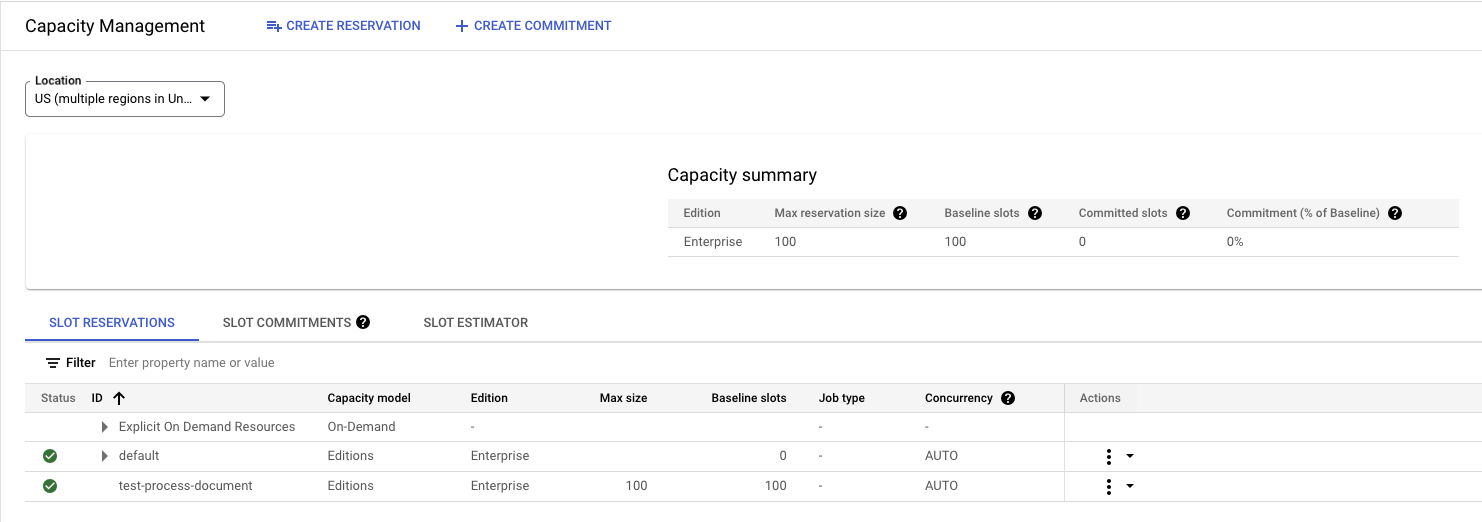

Create a reservation:

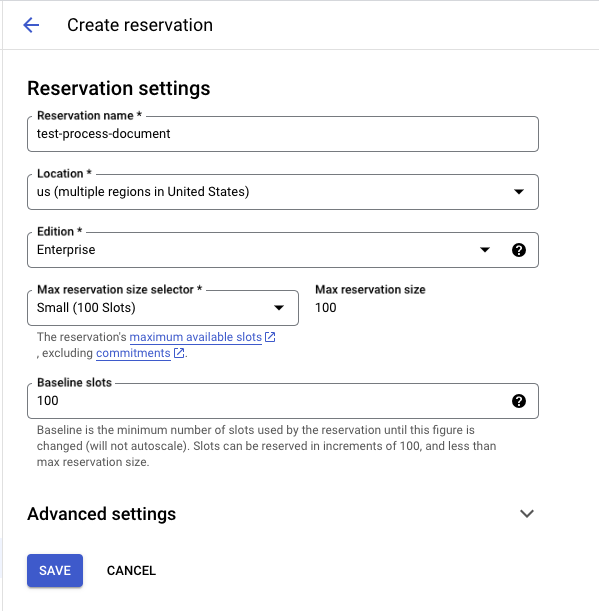

Create an assignment for the new reservation:

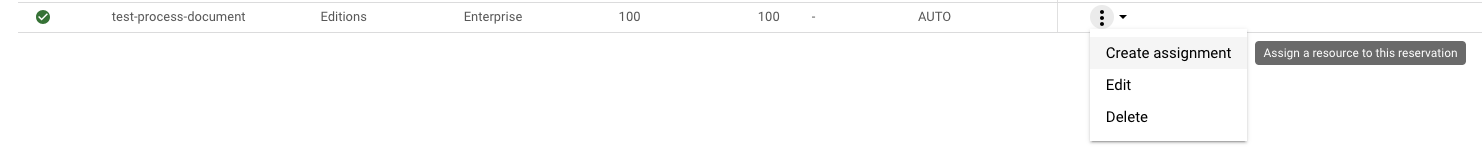

Fill in the assignment details: Job Type = QUERY and select the current project

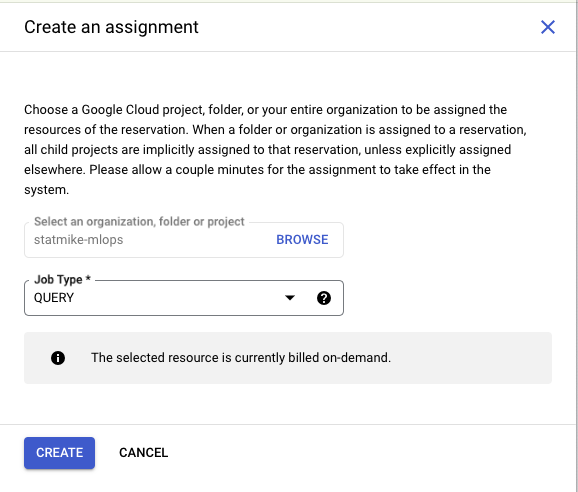

Revisit the capacity management console, expand the new reservation, and review the assignment of the current project:

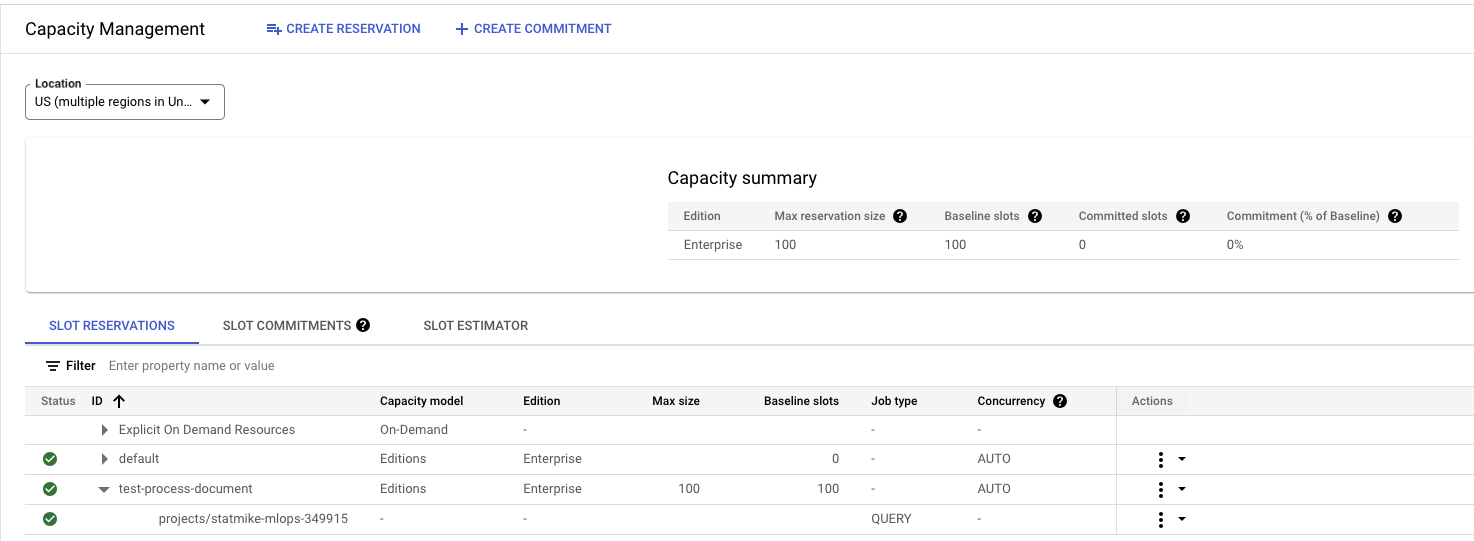

### BigQuery Dataset - Create

In [128]:
try:
    ds = bq.get_dataset(f'{BQ_PROJECT}.{BQ_DATASET}')
    print('Found the BigQuery Dataset: ', ds.full_dataset_id)
except:
    ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
    ds.location = BQ_REGION
    ds.labels = {'series': f'{SERIES}'}
    ds = bq.create_dataset(dataset = ds, exists_ok = True)
    print('Created the BigQuery Dataset: ', ds.full_dataset_id)

Found the BigQuery Dataset:  statmike-mlops-349915:working_with_docai


### BigQuery Object Table - Link Documents In GCS



In [129]:
# Create Remote Model In BigQuery
query = f"""
CREATE OR REPLACE EXTERNAL TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_DOCUMENTS`
    WITH CONNECTION `{BQ_PROJECT}.{BQ_REGION}.{SERIES}_{EXPERIMENT}`
    OPTIONS(
        object_metadata = 'SIMPLE',
        metadata_cache_mode = 'MANUAL',
        uris = ['gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/*']
    )
"""
job = bq.query(query = query)
job.result()
job.state

'DONE'

In [130]:
query = f"""
SELECT uri
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_DOCUMENTS`
"""
bq.query(query = query).to_dataframe()['uri'].tolist()

['gs://statmike-mlops-349915/working-with-docai/from-bigquery/shared files/docs/bill.pdf']

### BigQuery Remote Model - Document AI With BigQuery ML

BigQuery ML can `Create Model`'s that are actually connections to Remote Models. [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model)

Using the `REMOTE_SERVICE_TYPE = "cloud_ai_document_v1"` option will link to Document AI.
- [Documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-process-document)


#### Connection Requirement

To make a remote connection using BigQuery ML, BigQuery uses a CLOUD_RESOURCE connection. [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model#connection)

Create a new connection with type `CLOUD_RESOURCE`: First, check for existing connection.

In [131]:
try:
    response = bq_connection.ConnectionServiceClient().get_connection(
            request = bq_connection.GetConnectionRequest(
                name = f"projects/{BQ_PROJECT}/locations/{BQ_REGION}/connections/{SERIES}_{EXPERIMENT}"
            )
    )
    print(f'Found existing connection with service account: {response.cloud_resource.service_account_id}')
    service_account = response.cloud_resource.service_account_id
except Exception:
    request = bq_connection.CreateConnectionRequest(
        {
            "parent": f"projects/{BQ_PROJECT}/locations/{BQ_REGION}",
            "connection_id": f"{SERIES}_{EXPERIMENT}",
            "connection": bq_connection.types.Connection(
                {
                    "friendly_name": f"{SERIES}_{EXPERIMENT}",
                    "cloud_resource": bq_connection.CloudResourceProperties({})
                }
            )
        }
    )
    response = bq_connection.ConnectionServiceClient().create_connection(request)
    print(f'Created new connection with service account: {response.cloud_resource.service_account_id}')
    service_account = response.cloud_resource.service_account_id

Found existing connection with service account: bqcx-1026793852137-te86@gcp-sa-bigquery-condel.iam.gserviceaccount.com


Assign the service account the Vertex AI User role:

In [132]:
!gcloud projects add-iam-policy-binding {BQ_PROJECT} --member=serviceAccount:{service_account} --role=roles/documentai.viewer

Updated IAM policy for project [statmike-mlops-349915].
bindings:
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:bqcx-1026793852137-bmph@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-dyw1@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-pdxa@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-te86@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-tqpc@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-zfly@gcp-sa-big

In [133]:
!gcloud projects add-iam-policy-binding {BQ_PROJECT} --member=serviceAccount:{service_account} --role=roles/documentai.apiUser

Updated IAM policy for project [statmike-mlops-349915].
bindings:
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:bqcx-1026793852137-bmph@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-dyw1@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-pdxa@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-te86@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-tqpc@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-zfly@gcp-sa-big

In [134]:
!gcloud projects add-iam-policy-binding {BQ_PROJECT} --member=serviceAccount:{service_account} --role=roles/storage.objectViewer

Updated IAM policy for project [statmike-mlops-349915].
bindings:
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:bqcx-1026793852137-bmph@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-dyw1@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-pdxa@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-te86@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-tqpc@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-zfly@gcp-sa-big

### Create The Remote Model In BigQuery


In [135]:
# Create Remote Model In BigQuery
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_MODEL`
    REMOTE WITH CONNECTION `{BQ_PROJECT}.{BQ_REGION}.{SERIES}_{EXPERIMENT}`
    OPTIONS(
        REMOTE_SERVICE_TYPE = 'cloud_ai_document_v1',
        DOCUMENT_PROCESSOR = "{PARSER.default_processor_version}"
    )
"""
job = bq.query(query = query)
job.result()
job.state

'DONE'

### Process Documents with SQL Using ML.PROCESS_DOCUMENT

In [136]:
# CREATE table of processed documents
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_DOCUMENTS-PROCESSED` AS
    SELECT *
    FROM ML.PROCESS_DOCUMENT(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_MODEL`,
        TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_PREFIX}_DOCUMENTS`
    )
    WHERE content_type = 'application/pdf'
"""
job = bq.query(query = query)
job.result()
job.state

'DONE'

## Remove Resources

- BigQuery Reservation (if created for this notebook)
- BigQuery Dataset: Object Table, Model, Processed Documents
- BigQuery Remote Connection

### Delete Reservation

First, delete the assignment to the reservation, then delete the reservation:

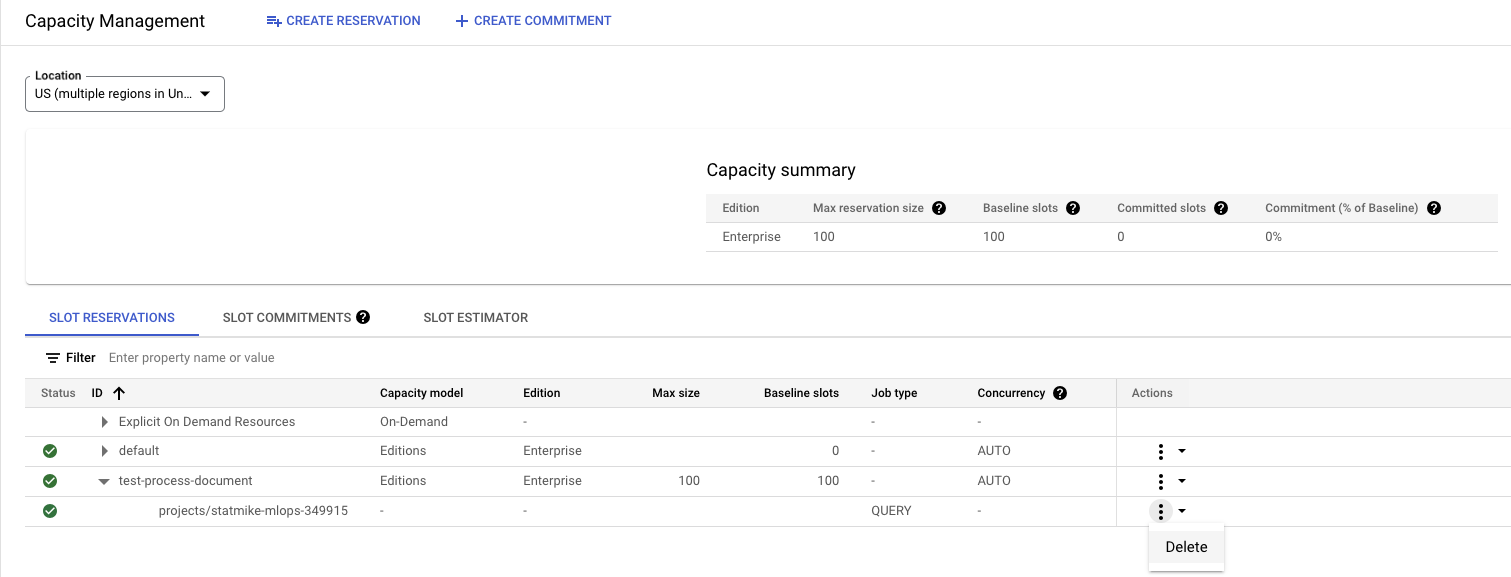

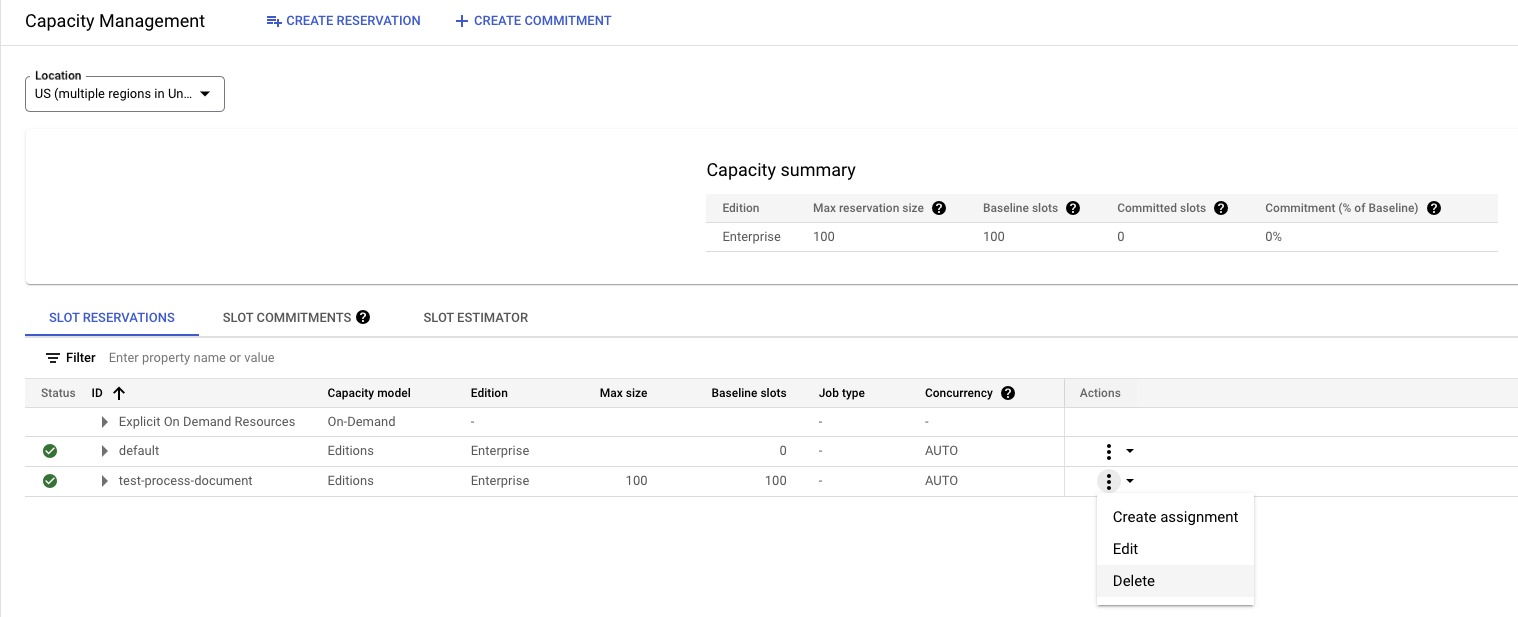